# **Theoretical** **Part**

Indeed, matrix decompositions are often the workhorse algorithms for scientific computing applications in the areas of applied mathematics, statistical computing, and machine learning. Despite our ever-increasing computational power, the emergence of large-scale datasets has severely challenged our ability to analyze data using traditional matrix algorithms. Moreover, the growth of data collection is far outstripping computational performance gains. The computationally expensive singular value decomposition (SVD) is the most ubiquitous method for dimensionality reduction, data processing and compression. The concept of randomness has recently been demonstrated as an effective strategy to easing the computational demands of low-rank approximations from matrix decompositions such as the SVD, thus allowing for a scalable architecture for modern“big data” applications.

The basic idea of probabilistic matrix algorithms is to employ a degree of randomness in order to derive a smaller matrix from a high-dimensional matrix, which captures the essential information. Thus, none of the “randomness” should obscure the dominant spectral information of the data as long as the input matrix features some low-rank structure. Then, a deterministic matrix factorization algorithm is applied to the smaller matrix to compute a near-optimal low-rank approximation. The principal concept is sketched in Figure 1.
<img src="fig1.jpg" style="height:300px"> 

General Idea of the randomized algorithm
<br>
In the following, we advocate the probabilistic framework, formulated by Halko et al. (2011b), to compute a near-optimal low-rank approximation. Conceptually, this framework splits the computational task into two logical stages:
<br>
• Stage A: Construct a low dimensional subspace that approximates the column space of $A$. This means, the aim is to find a matrix $Q \in R^{m \times k}$ with orthonormal columns such that $A \approx QQ^T A$ is satisfied.
<br>
• Stage B: Form a smaller matrix $B=Q^T A \in R^{k \times n}$, i.e., restrict the high-dimensional
input matrix to the low-dimensional space spanned by the near-optimal basis $Q$. The
smaller matrix $B$ can then be used to compute a desired low-rank approximation.


Stage A: Computing the near-optimal basis
First, we aim to find a near-optimal basis Q for the matrix A such that $A \approx QQ^T A$ is satisfied. The desired target rank k is assumed to be $k << min{m, n}$. Specifically, P=QQT is a linear orthogonal projector.

The generic randomized algorithm

Stage A: Computing the near-optimal basis

First, we aim to find a near-optimal basis Q for the matrix A such that

$$A \approx QQ^T A$$

is satisfied. The desired target rank k is assumed to be k << min{m, n}. Specifically, P := QQ^T is a linear orthogonal projector. A projection operator corresponds to a linear subspace, and transforms any vector to its orthogonal projection on the subspace. This is illustrated in Figure, where a vector x is confined to the column space col(A).

<img src="1.jpg" style="height:300px">

Figure: Geometric illustration of the orthogonal projection operator P. A vector x ∈ $R^M$ is restricted to the column space of A, where Px ∈ col(A).

The concept of random projections can be used to sample the range (column space) of the input
matrix A in order to efficiently construct such a orthogonal projector. Random projections
are data agnostic, and constructed by first drawing a set of k random vectors ${ωi}^k$ i=1, for
instance, from the standard normal distribution. Probability theory guarantees that random
vectors are linearly independent with high probability. Then, a set of random projections
${yi}^k$ i=1 is computed by mapping A to low-dimensional space:

                         yi := Aωi for i = 1, 2, . . . , k.
In other words, this process forms a set of independent randomly weighted linear combinations of the columns of A, and reduces the number of columns from n to k. While the input matrix is compressed, the Euclidean distances between the original data points are approximately preserved. Random projections are also well known as the Johnson-Lindenstrauss (JL) transform (Johnson and Lindenstrauss 1984), and we refer to Ahfock, Astle, and Richardson (2017) for a recent statistical perspective.

Equation 3 can be efficiently executed in parallel. Therefore, let us define the random test matrix Ω ∈ Rn×k, which is again drawn from the standard normal distribution, and the columns of which are given by the vectors {ωi}. The samples matrix $Q \in R^{m \times k}$, also denoted as sketch, is then obtained by post-multiplying the input matrix by the random test matrix $$ Y := A\Omega $$
Once Y is obtained, it only remains to orthonormalize the columns in order to form a natural basis $Q \in R^{m \times k}$ This can be efficiently achieved using the QR-decomposition Y =: QR, and it follows that Equation 2 is satisfied.

Stage B: Compute the smaller matrix

Now, given the near-optimal basis Q, we aim to find a smaller matrix $B \in R^{k \times n}$. Therefore, we project the high-dimensional input matrix A to low-dimensional space $$B:= Q^*A$$
Geometrically, this is a projection (i.e., a linear transformation) which takes points in a high-dimensional space into corresponding points in a low-dimensional space, illustrated in


<img src="2.jpg" style="height:300px">


Figure 2: Points in a high-dimensional space are projected into low-dimensional space, while the geometric structure is preserved in an Euclidean sense.

This process preserves the geometric structure of the data in an Euclidean sense, i.e., the length of the projected vectors as well as the angles between the projected vectors are preserved. This is, due to the invariance of inner products (Trefethen and Bau 1997). Substituting Equation 5 into 2 yields then the following low-rank approximation

                         A     ≈    Q       B
                       m × n      m × k   k × n

This decomposition is referred to as the QB decomposition. Subsequently, the smaller matrix B can be used to compute a matrix decomposition using a traditional algorithm.










# **Comparison**

**FSVD and Standard SVD Differance**

In [1]:
from __future__ import absolute_import, division, print_function
import numpy.testing as npt
import numpy as np
import scipy as sp
import scipy.sparse
import scipy.sparse.linalg
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.utils.extmath import randomized_svd

In [8]:
"""Fast SVD"""



k = 150
def fsvd(A, k=k, i=1, usePowerMethod=1, **kwargs):    
    """takes an F-matrix and returns eigenvalues and eigenvectors of the ssvd method
    Based on algorithm described in 'An Algorithm for the Principal Component analysis
    of Large Data Sets' by N. Halko, P.G. Martinsson, Y. Shkolnisky, and M. Tygert
    and Matlab code: http://stats.stackexchange.com/questions/2806/best-pca-algorithm-for-huge-number-of-features
    
    F_matrix: F_matrix
    k: dimensions
    i: is the number of levels of the Krylov method to use, for most applications, i=1 or i=2 is sufficient
    userPowerMethod: changes the power of the spectral norm (minimizing the error). See p11/eq8.1 DOI = {10.1137/100804139}  
    """
    m, n = A.shape
    
    if m < n:
        A = A.T
    
    m, n = A.shape    #dimensions could have changed in above Transpose
    l = k + 2

    # entries independent, identically distributed Gaussian random variables of zero mean and unit variance
    G = np.random.standard_normal(size=(n, l))   
    if usePowerMethod == 1:
        H = np.dot(A, G)
        for x in range(i):
            H = np.dot(A, np.dot(A.T, H))   #enhance decay of singular values
    else:
        H = np.dot(A, G)
        tmp = np.dot(A, np.dot(A.T, H))
        H = np.hstack((H, np.dot(A, np.dot(A.T, H))))
        for x in range(i-1):
            H = np.hstack((H, np.dot(A, np.dot(A.T, tmp)))) ### tmp is currently undefined, inquiring
    
    Q, R = np.linalg.qr(H)    #pivoted QR-decomposition
    T = np.dot(A.T, Q) #step 3
    
    Vt, St, W = np.linalg.svd(T, full_matrices=False) #step 4 (as documented in paper)
    W = W.T
    
    Ut = np.dot(Q,W)

    if m < n:
        V_fsvd = Ut[:,:k]
        U_fsvd = Vt[:,:k]
#         V_fsvd = Ut
#         U_fsvd = Vt

    else:
        U_fsvd = Ut[:,:k]                               ## rank k approximation
        V_fsvd = Vt[:,:k]                               ## rank k approximation
#         V_fsvd = Ut        #full rank approximation
#         U_fsvd = Vt        #full rank approximation
    
#     #drop imaginary component, if we got one
#     eigvals = (St[:k]**2).real
#     eigvecs = U_fsvd.real

#     return eigvals, eigvecs.T
    return U_fsvd, St[:k], V_fsvd                       ## rank k approximation
#     return U_fsvd, St, V_fsvd     #full rank approximation

In [9]:
"""Creating a rank k random matrix"""

# times_fsvd = []
# times_rsvd = []
# times_svd = []

A = np.random.random((12000, 150)) @ np.random.random((150, 800))
# a = %timeit -o fsvd(A)
# b = %timeit -o randomized_svd(A, n_components = 150)
# c = %timeit -o np.linalg.svd(A, full_matrices=False)

# times_fsvd.append(a.average)
# times_rsvd.append(b.average)
# times_svd.append(c.average

In [10]:
from numpy.linalg import matrix_rank
matrix_rank(A)

150

In [11]:
"""Fast SVD on random matrix"""

U_A, st_A, V_A = fsvd(A, i=3, k=150, usePowerMethod=0)

A_hat = (U_A * st_A) @ V_A.T

In [12]:
print('Shape of random matrix Approximation: ',A_hat.shape)
print('rank of matrix Approximation: ',matrix_rank(A_hat))

Shape of random matrix Approximation:  (12000, 800)
rank of matrix Approximation:  150


In [13]:
"""Randomized SVD on random matrix"""

svd = randomized_svd(A, n_components = 150)
u, sigma, v = svd

A_r = (u * sigma) @ v

In [14]:
"""Full svd on random matrix"""

u, zigma, v = np.linalg.svd(A, full_matrices=False)
full_svd = (u * zigma) @ v

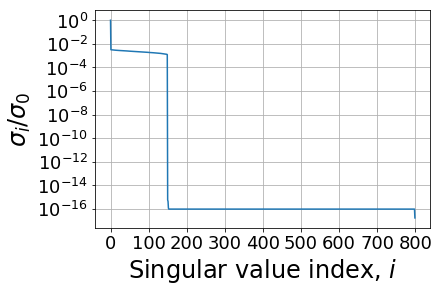

In [15]:
"""Fast SVD workes on the matrix which singular values decend fast"""
"""test to show our random matrix has/n't this criteria"""


plt.semilogy(zigma/zigma[0])
plt.ylabel(r"$\sigma_i / \sigma_0$", fontsize=24)
plt.xlabel(r"Singular value index, $i$", fontsize=24)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.grid(True)

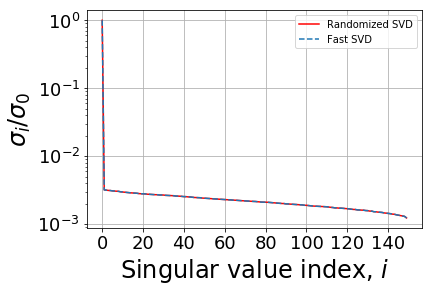

In [16]:
"""show that output of fast SVD and Randomized SVD still retain this criteria"""

plt.semilogy(sigma/sigma[0], 'r')
plt.semilogy(fsvd(A)[1]/fsvd(A)[1][0], '--')
plt.ylabel(r"$\sigma_i / \sigma_0$", fontsize=24)
plt.xlabel(r"Singular value index, $i$", fontsize=24)
plt.legend(['Randomized SVD', 'Fast SVD'])
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.grid(True)

In [17]:
"""Calculate the time taking to compute all three methods"""

print('time for randomized SVD : ')
%timeit randomized_svd(A, n_components = 150)
print('')
print('time for fast SVD : ')
%timeit fsvd(A, i=2, k=100, usePowerMethod=0)
print('')
print('time for SVD : ')
%timeit np.linalg.svd(A, full_matrices=False)

time for randomized SVD : 
354 ms ± 14.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

time for fast SVD : 
297 ms ± 11.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

time for SVD : 
505 ms ± 15 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [18]:
"""Error for our approximations (Fast SVD and Randomized SVD) """

print('error for fsvd = ', np.linalg.norm((A - A_hat), 'fro'))        ## rank k approximation
print('error for rsvd = ',np.linalg.norm((A - A_r), 'fro'))          ## rank k approximation

error for fsvd =  6.113780686713985e-10
error for rsvd =  4.1902832436553126e-10


In [19]:
times_fsvd = []
times_svd = []
for each in range (1, 11):
    A = np.random.random((1000 * each, 100 * each))
    a = %timeit -o fsvd(A)
    b = %timeit -o np.linalg.svd(A, full_matrices=False)
    times_fsvd.append(a.average)
    times_svd.append(b.average)

16.2 ms ± 2.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.81 ms ± 54.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
12.5 ms ± 336 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
11.3 ms ± 13.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
20.5 ms ± 755 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
34.6 ms ± 883 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
32.2 ms ± 3.37 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
74.6 ms ± 3.28 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
45.8 ms ± 3.93 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
133 ms ± 3.02 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
54.2 ms ± 1.69 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
199 ms ± 2.99 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
71 ms ± 4.35 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
287 ms ± 4.06 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
84 ms ± 2.28 ms p

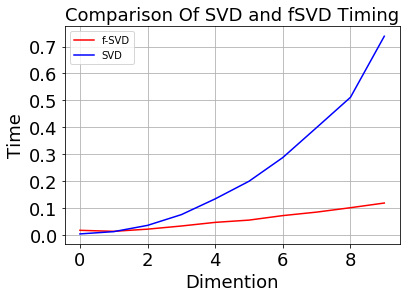

In [20]:
plt.plot(times_fsvd, 'r')
plt.plot(times_svd, 'b')
plt.title("Comparison Of SVD and fSVD Timing", fontsize=18)
plt.ylabel("Time", fontsize=18)
plt.xlabel("Dimention", fontsize=18)
plt.legend(['f-SVD', 'SVD'])
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.grid(True)

**RSVD and Standard** **SVD**

In [21]:
A = np.random.random((100,100))
u, s, vt = randomized_svd(A, n_components = 2)

In [22]:
times_rsvd = []
times_svd = []
for each in range (1, 11):
    A = np.random.random((1000 * each, 100 * each))
    a = %timeit -o randomized_svd(A, n_components = 2)
    b = %timeit -o np.linalg.svd(A, full_matrices=False)
    times_rsvd.append(a.average)
    times_svd.append(b.average)

1.52 ms ± 5.92 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
2.9 ms ± 75.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
4.09 ms ± 302 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
11.7 ms ± 269 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
7.99 ms ± 17.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
34.6 ms ± 114 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
14.6 ms ± 394 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
72.2 ms ± 1.21 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
23 ms ± 475 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
137 ms ± 5.29 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
36.6 ms ± 2.52 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
221 ms ± 18.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
43.7 ms ± 1.44 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
351 ms ± 26.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
58.1 ms ± 3.1 

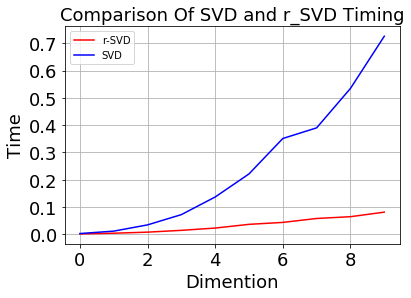

In [23]:
plt.plot(times_rsvd, 'r')
plt.plot(times_svd, 'b')
plt.title("Comparison Of SVD and r_SVD Timing", fontsize=18)
plt.ylabel("Time", fontsize=18)
plt.xlabel("Dimention", fontsize=18)
plt.legend(['r-SVD', 'SVD'])
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.grid(True)

## **Complexity**

1. RSVD: $O(mnlog(k) + (m+n)k^2)$ flops


2. Full SVD: $O(min(mn^2,m^2n))$


3. Truncated SVD:  $O(k^2m)$

# Test one a pictures:

In [40]:
"""Import an image"""

from PIL import Image
img = Image.open('moana_16spp_oidn.jpg')

In [41]:
import numpy as np
arr = np.array(img)
arr.shape

(804, 1920, 3)

In [42]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.144])
gray = rgb2gray(arr)
gray.shape

(804, 1920)

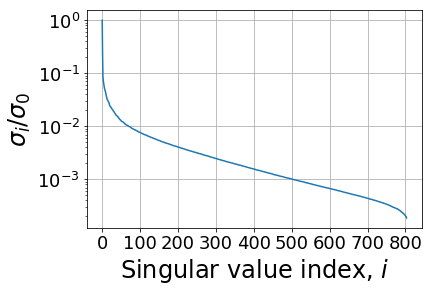

In [43]:
u, s, v = np.linalg.svd(gray, full_matrices=False)
svd = (u * s) @ v
plt.semilogy(s/s[0])
plt.ylabel(r"$\sigma_i / \sigma_0$", fontsize=24)
plt.xlabel(r"Singular value index, $i$", fontsize=24)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.grid(True)

In [44]:
U_gray, s_gray, V_gray = fsvd(gray, i=3, k=150, usePowerMethod=0)

fgray = (U_gray * s_gray) @ V_gray.T
fgray = fgray.T

In [45]:
print('Shape of image: ',fgray.shape)
print('Approximate rank of image: ',matrix_rank(fgray))

Shape of image:  (804, 1920)
Approximate rank of image:  150


In [46]:
U_r, s_r, V_r = randomized_svd(gray, n_components = 150)


rgray = (U_r * s_r) @ V_r

In [47]:
print('image randomized_svd Shape: ',fgray.shape)
print('Approximate image rank: ',matrix_rank(fgray))

image randomized_svd Shape:  (804, 1920)
Approximate image rank:  150


In [48]:
u_gray, s_gray, v_gray = np.linalg.svd(gray, full_matrices=False)
full_gray = (u_gray * s_gray) @ v_gray

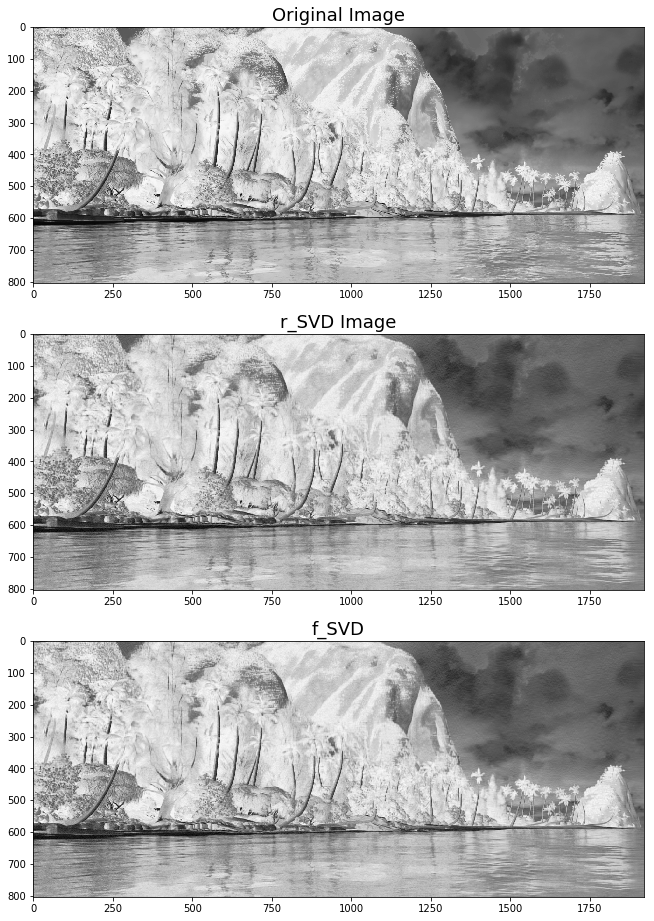

In [49]:
plt.subplot(3,1,1)

gray_plot = plt.imshow(gray,  cmap='Greys',  interpolation='nearest')
plt.title("Original Image", fontsize=18)
plt.subplot(3,1,2)
imgplot = plt.imshow(fgray, cmap='Greys',  interpolation='nearest')    ## rank k approximation
plt.title("r_SVD Image", fontsize=18)
plt.subplot(3,1,3)
imgplot = plt.imshow(rgray,  cmap='Greys',  interpolation='nearest')    ## rank k approximation
plt.title("f_SVD", fontsize=18)
fig = plt.gcf()
fig.set_size_inches(30, 16)
plt.show()

In [50]:
print("error for fsvd = ", np.linalg.norm(gray - fgray, 'fro'))
print("error for rsvd = ", np.linalg.norm(gray - rgray, 'fro'))

error for fsvd =  7241.777162576553
error for rsvd =  7266.386107626125


In [51]:
print('time for randomized SVD : ')
%timeit randomized_svd(gray, n_components = 150)
print('')
print('time for fast SVD : ')
%timeit fsvd(gray, i=1, k=100, usePowerMethod=0)
print('')
print('time for SVD : ')
%timeit np.linalg.svd(gray, full_matrices=False)

time for randomized SVD : 
67.1 ms ± 1.08 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

time for fast SVD : 
38.3 ms ± 1.37 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

time for SVD : 
179 ms ± 13.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Spectral Graph Partitioning


In [52]:
"""
DM1

Implementation of the Spectral Partition Algorithm
"""
import numpy as np
import subprocess
import logging


def import_nodes(nodes_file):
    """
    Import the nodes from the file
    """

    edges = []
    adjacency_matrix = {}
    number_nodes = 0

    # Open the file
    with open("facebook_combined.txt", "r") as datafile:
        for line in datafile:
            node1, node2 = line.split()
            node1 = int(node1)
            node2 = int(node2)
            edges.append({node1, node2})
            number_nodes = max(number_nodes, node1, node2)

    number_nodes += 1  # We only had the maximum index of the nodes
    logging.info("Imported {} nodes with {} edges from {}".format(number_nodes, len(edges), nodes_file))

    # Initiate empty matrix
    adjacency_matrix = np.zeros((number_nodes, number_nodes))

    # Fill the matrix
    for node1, node2 in edges:
        # The adjancency matrix is symmetric
        adjacency_matrix[node1][node2] = 1
        adjacency_matrix[node2][node1] = 1

    return (number_nodes, edges, adjacency_matrix)


def degree_nodes(adjacency_matrix, number_nodes):
    """
    Compute the degree of each node
    Returns the vector of degrees
    """

    d = []
    for i in range(number_nodes):
        d.append(sum([adjacency_matrix[i][j] for j in range(number_nodes)]))

    return d


def print_graph(number_nodes, edges, partition, outputfile):
    """
    Writes a .gv file to use with dot
    """
    with open("graph.gv", "w") as gv:
        gv.write("strict graph communities {")

        for node, community in enumerate(partition):
            gv.write("node{} [color={}];".format(node, "red" if community else "blue"))

        for node1, node2 in edges:
            gv.write("node{} -- node{};".format(node1, node2))

        gv.write("}")
        gv.close()

    subprocess.call(["dot", "-Tpng", "graph.gv", "-o", outputfile])
    logging.warning("Wrote {} with the two communities.".format(outputfile))


def algorithm(nodes_file):
    """
    The Spectral Partitioning Algorithm
    """

    logging.warning("Computing Adjacency Matrix...")

    number_nodes, edges, adjacency_matrix = import_nodes(args.nodes_file)
    logging.debug("Adjacency matrix:\n", adjacency_matrix)

    logging.warning("Computing the degree of each node...")
    degrees = degree_nodes(adjacency_matrix, number_nodes)
    logging.debug("Degrees: ", degrees)

    logging.warning("Computing the Laplacian matrix...")
    laplacian_matrix = np.diag(degrees) - adjacency_matrix
    logging.debug("Laplacian matrix:\n", laplacian_matrix)

    logging.warning("Computing the eigenvectors and eigenvalues...")
    eigenvalues, eigenvectors = np.linalg.eigh(laplacian_matrix)

    logging.info("Found eigenvalues: ", eigenvalues)

    # Index of the second eigenvalue
    index_fnzev = np.argsort(eigenvalues)[1]

    logging.debug("Eigenvector for #{} eigenvalue ({}): ".format(
        index_fnzev, eigenvalues[index_fnzev]), eigenvectors[:, index_fnzev])

    # Partition on the sign of the eigenvector's coordinates
    partition = [val >= 0 for val in eigenvectors[:, index_fnzev]]

    # Compute the edges in between
    nodes_in_A = [nodeA for (nodeA, nodeCommunity) in enumerate(partition) if nodeCommunity]
    nodes_in_B = [nodeB for (nodeB, nodeCommunity) in enumerate(partition) if not nodeCommunity]
    edges_in_between = []
    for edge in edges:
        node1, node2 = edge
        if node1 in nodes_in_A and node2 in nodes_in_B \
                or node1 in nodes_in_B and node2 in nodes_in_A:
            edges_in_between.append(edge)

    # Display the results
    logging.warning("Partition computed: nbA={} nbB={} (total {}), {} edges in between".format(
        len(nodes_in_A),
        len(nodes_in_B),
        number_nodes,
        len(edges_in_between),
    ))

    return number_nodes, edges, partition


if __name__ == '__main__':
    import argparse

    # Configure logging
    FORMAT = '%(asctime)s.%(msecs)03d %(message)s'
    logging.basicConfig(format=FORMAT, datefmt='%H:%M:%S')

    parser = argparse.ArgumentParser(description="Compute the partition of a "
        "graph using the Spectral Partition Algorithm.")

    parser.add_argument('--nodes-file', '-f', help='the file containing the nodes',
                        default='demo_nodes.txt')
    parser.add_argument('--output-file', '-o', help='the filename of the'
                        ' communities PNG graph to be written')

    args = parser.parse_args()

    # Run the algorithm
    number_nodes, edges, partition = algorithm(args.nodes_file)

    if args.output_file:
        # Print the graph
        print_graph(number_nodes, edges, partition, outputfile=args.output_file)


19:15:03.028 Computing Adjacency Matrix...
19:15:03.398 Computing the degree of each node...
19:15:07.470 Computing the Laplacian matrix...
19:15:07.651 Computing the eigenvectors and eigenvalues...
19:15:17.124 Partition computed: nbA=754 nbB=3285 (total 4039), 40 edges in between


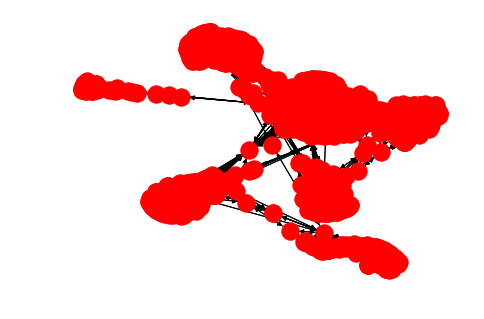

<Figure size 36000x36000 with 0 Axes>

In [53]:
y = import_nodes("facebook_combined.txt")[2]
G = nx.DiGraph(y)

nx.draw(G)
plt.figure(figsize = (500,500))
plt.show()

In [54]:
y.shape

(4039, 4039)

In [55]:
edges = []
adjacency_matrix = {}
number_nodes = 0
with open("facebook_combined.txt", "r") as datafile:
    for line in datafile:
        node1, node2 = line.split()
        node1 = int(node1)
        node2 = int(node2)
        edges.append({node1, node2})
        number_nodes = max(number_nodes, node1, node2)
number_nodes, edges, adjacency_matrix = import_nodes(args.nodes_file)
degrees = degree_nodes(adjacency_matrix, number_nodes)
laplacian_matrix = np.diag(degrees) - adjacency_matrix

In [56]:
%timeit np.linalg.eigh(laplacian_matrix)

5.76 s ± 262 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [57]:
%timeit fsvd(laplacian_matrix)

163 ms ± 1.83 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Face Recognition


Eigenfaces is the name given to a set of eigenvectors when they are used in the computer vision problem of human face recognition.

There's a good algorithmic description at Wikipedia on Eigenface and it goes like this:
* Prepare the data with each column representing an image.
* Subtract the mean image from the data.
* Calculate the eigenvectors and eigenvalues of the covariance matrix.
* Find the optimal transformation matrix by selecting the principal components (eigenvectors with largest eigenvalues).
* Project the centered data into the subspace.




### Main idea behind eigenfaces

Suppose $\Gamma$ is an $N^2 \times 1$ vector,corresponding to an $N\times N$ face image I.

<img src="EF2.png" style="height:300px">

The idea is to represent $\Gamma (\phi =\Gamma-mean face)$ into a low-dimensional space.

$$\phi − mean = w_1u_1+w_2u_2+...w_Ku_K (K<<N2)$$

#### Computation of the eigenfaces:

1-  obtain face images $I_1,I_2,...,I_M$(training faces)(the face images must becenteredand of the samesize)

<img src="trainingset-300x300.png" style="height:300px">

2- represent every image $I_i$ as a vector $\Gamma_i$

3- compute the average face vector $\Psi$

$$ \Psi = \frac{1}{M} \Sigma_{1} ^{M}  \Gamma_i$$

4- subtract the mean face

$$\Phi = \Gamma_i - \Psi$$

<img src="median.png" style="height:300px">

5- compute the covariance matrix $C$

$$C =  \frac{1}{M}  \Sigma_{1} ^{M} \Phi_n \Phi_n ^T = AA^T (N^2 x N^2 matrix)$$

where $$A = [\Phi_1 \Phi_2 ... \Phi_M]$$

6- compute the eigenvectors ui of $AA^T$

<img src="Extract eigenvectors.png" style="height:200px">

<img src="Calculate eigenfaces.png" style="height:300px">

7- keep only K eigenvectors (corresponding to the K largest eigenvalues)

<img src="Choose the most significant eigenfaces.png" style="height:300px">


#### Representing faces onto this basis:
Each face (minus the mean) $\phi_i$ in the training set can be represented as a linear combination of the best K eigenvectors:

$$\Phi\hat{} - mean = \Sigma_{1} ^{M} w_j u_j , (w_j = u_j ^T \Phi_i)$$


<img src="EF7.png" style="height:300px">

Each normalized training face $\phi_i$ is represented in this basis by a vector:

$$\Omega_i =  \begin{pmatrix}w_1 ^i\\w_2 ^i \\ ... \\w_3 ^i\end{pmatrix} , i = 1, 2, ... , M$$

<img src="Calculate weights.png" style="height:300px">

##### Face Recognition 


Step1 : normalize $\Phi = \Gamma - \Psi$

step2 : project on the eigenspace
$\Phi\hat{} - mean = \Sigma_{1} ^{M} w_j u_j , (w_j = u_j ^T \Phi_i)$

step3 : represent $\Phi \:\:$ as $\Omega =  \begin{pmatrix}w_1\\w_2 \\ ... \\w_3 \end{pmatrix}$

step4 : find $e_r = min_{l}\|\Omega - \Omega^l\|$

step5 : if $e_l < T_r \:\:$, then$\:\Gamma$ is recognized as face l from the training set.

<img src="Interpret the distance.png" style="height:300px">

###### References: 

http://laid.delanover.com/explanation-face-recognition-using-eigenfaces/

https://en.wikipedia.org/wiki/Eigenface

https://pythonmachinelearning.pro/face-recognition-with-eigenfaces/

https://github.com/vutsalsinghal/EigenFace

## Read Images

In [59]:
# Import libraries
from matplotlib import pyplot as plt
from matplotlib.image import imread
import numpy as np
import os

In [60]:
dataset_path = 'Dataset/'
dataset_dir  = os.listdir(dataset_path)

width  = 195
height = 231

Train Images:


/home/hekmat/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


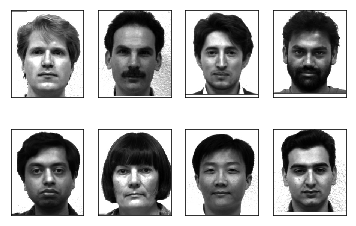

Test Images:


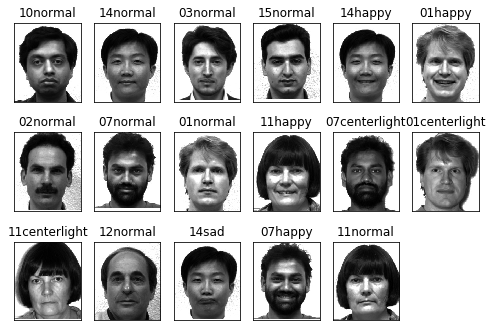

In [61]:
print('Train Images:')
train_image_names = ['subject01.normal.jpg', 'subject02.normal.jpg', 'subject03.normal.jpg', 'subject07.normal.jpg', 'subject10.normal.jpg', 'subject11.normal.jpg', 'subject14.normal.jpg', 'subject15.normal.jpg']
training_tensor   = np.ndarray(shape=(len(train_image_names), height*width), dtype=np.float64)

for i in range(len(train_image_names)):
    img = plt.imread(dataset_path + train_image_names[i])
    training_tensor[i,:] = np.array(img, dtype='float64').flatten()
    plt.subplot(2,4,1+i)
    plt.imshow(img, cmap='gray')
    plt.tick_params(labelleft='off', labelbottom='off', bottom='off',top='off',right='off',left='off', which='both')
plt.show()

print('Test Images:')
test_image_names = dataset_dir#[i for i in dataset_dir if i not in train_image_names]
testing_tensor   = np.ndarray(shape=(len(test_image_names), height*width), dtype=np.float64)

for i in range(len(test_image_names)):
    img = imread(dataset_path + test_image_names[i])
    testing_tensor[i,:] = np.array(img, dtype='float64').flatten()
    plt.subplot(3,6,1+i)
    plt.title(test_image_names[i].split('.')[0][-2:]+test_image_names[i].split('.')[1])
    plt.imshow(img, cmap='gray')
    plt.subplots_adjust(right=1.2, top=1.2)
    plt.tick_params(labelleft='off', labelbottom='off', bottom='off',top='off',right='off',left='off', which='both')
plt.show()

## Mean face

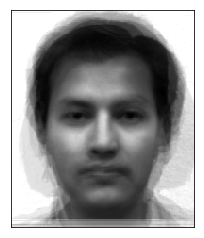

In [62]:
mean_face = np.zeros((1,height*width))

for i in training_tensor:
    mean_face = np.add(mean_face,i)

mean_face = np.divide(mean_face,float(len(train_image_names))).flatten()

plt.imshow(mean_face.reshape(height, width), cmap='gray')
plt.tick_params(labelleft='off', labelbottom='off', bottom='off',top='off',right='off',left='off', which='both')
plt.show()

## Normalised faces

In [63]:
normalised_training_tensor = np.ndarray(shape=(len(train_image_names), height*width))

for i in range(len(train_image_names)):
    normalised_training_tensor[i] = np.subtract(training_tensor[i],mean_face)

### Display normalised faces

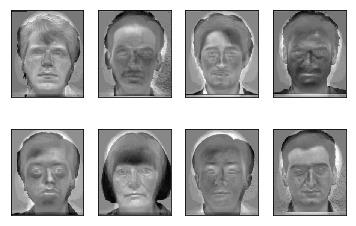

In [64]:
for i in range(len(train_image_names)):
    img = normalised_training_tensor[i].reshape(height,width)
    plt.subplot(2,4,1+i)
    plt.imshow(img, cmap='gray')
    plt.tick_params(labelleft='off', labelbottom='off', bottom='off',top='off',right='off',left='off', which='both')
plt.show()

In [65]:
normalised_training_tensor.shape

(8, 45045)

## Covariance matrix

In [66]:
cov_matrix = np.cov(normalised_training_tensor)
cov_matrix = np.divide(cov_matrix,8.0)
print('Covariance matrix of X: \n%s' %cov_matrix)

Covariance matrix of X: 
[[ 240.21425354  -54.37445049  -49.91300972 -167.04449305    6.71011608
    95.13549119   51.86167951 -122.58958706]
 [ -54.37445049  271.21637481  -39.69264581   66.46457924  -62.78262301
  -159.33970561  -96.7188796    75.22735047]
 [ -49.91300972  -39.69264581  223.857185     46.24225037  -32.6657127
  -134.1771553   -35.12864547   21.47773363]
 [-167.04449305   66.46457924   46.24225037  345.77440281  -80.00529939
  -267.06328206  -73.29909108  128.93093316]
 [   6.71011608  -62.78262301  -32.6657127   -80.00529939  256.35235515
   -63.58037876   53.02911913  -77.05757652]
 [  95.13549119 -159.33970561 -134.1771553  -267.06328206  -63.58037876
   747.14220277    1.26270451 -219.37987674]
 [  51.86167951  -96.7188796   -35.12864547  -73.29909108   53.02911913
     1.26270451  238.6557604  -139.66264741]
 [-122.58958706   75.22735047   21.47773363  128.93093316  -77.05757652
  -219.37987674 -139.66264741  333.05367046]]


In [67]:
cov_matrix.shape

(8, 8)

In [91]:

eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

%timeit np.linalg.eig(cov_matrix)




# print('Eigenvectors of Cov(X): \n%s' %eigenvectors)
# print('\nEigenvalues of Cov(X): \n%s' %eigenvalues)

# print('Eigenvectors of Cov(X): \n%s' %eigvecs.T)
# print('\nEigenvalues of Cov(X): \n%s' %eigvals)

36.1 µs ± 933 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [144]:
"""Fast SVD"""



k = 8
def fsvd(A, k=k, i=1, usePowerMethod=1, **kwargs):    
    """takes an F-matrix and returns eigenvalues and eigenvectors of the ssvd method
    Based on algorithm described in 'An Algorithm for the Principal Component analysis
    of Large Data Sets' by N. Halko, P.G. Martinsson, Y. Shkolnisky, and M. Tygert
    and Matlab code: http://stats.stackexchange.com/questions/2806/best-pca-algorithm-for-huge-number-of-features
    
    F_matrix: F_matrix
    k: dimensions
    i: is the number of levels of the Krylov method to use, for most applications, i=1 or i=2 is sufficient
    userPowerMethod: changes the power of the spectral norm (minimizing the error). See p11/eq8.1 DOI = {10.1137/100804139}  
    """
    m, n = A.shape
    
    if m < n:
        A = A.T
    
    m, n = A.shape    #dimensions could have changed in above Transpose
    l = k + 2

    # entries independent, identically distributed Gaussian random variables of zero mean and unit variance
    G = np.random.standard_normal(size=(n, l))   
    if usePowerMethod == 1:
        H = np.dot(A, G)
        for x in range(i):
            H = np.dot(A, np.dot(A.T, H))   #enhance decay of singular values
    else:
        H = np.dot(A, G)
        tmp = np.dot(A, np.dot(A.T, H))
        H = np.hstack((H, np.dot(A, np.dot(A.T, H))))
        for x in range(i-1):
            H = np.hstack((H, np.dot(A, np.dot(A.T, tmp)))) ### tmp is currently undefined, inquiring
    
    Q, R = np.linalg.qr(H)    #pivoted QR-decomposition
    T = np.dot(A.T, Q) #step 3
    
    Vt, St, W = np.linalg.svd(T, full_matrices=False) #step 4 (as documented in paper)
    W = W.T
    
    Ut = np.dot(Q,W)

    if m < n:
        V_fsvd = Ut[:,:k]
        U_fsvd = Vt[:,:k]
#         V_fsvd = Ut
#         U_fsvd = Vt

    else:
        U_fsvd = Ut[:,:k]                               ## rank k approximation
        V_fsvd = Vt[:,:k]                               ## rank k approximation
#         V_fsvd = Ut        #full rank approximation
#         U_fsvd = Vt        #full rank approximation
    
#     #drop imaginary component, if we got one
    eigvals = (St[:k]**2).real
    eigvecs = U_fsvd.real

    return eigvals, eigvecs.T
#     return U_fsvd, St[:k], V_fsvd                       ## rank k approximation
#     return U_fsvd, St, V_fsvd     #full rank approximation

In [111]:
eigenvalues, eigenvectors = fsvd (cov_matrix)

eigenvectors=eigenvectors.T

%timeit fsvd (cov_matrix, i=1, k=8, usePowerMethod=0)

105 µs ± 4.49 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [112]:
eigenvectors.shape

(8, 8)

In [113]:
eig_pairs = [(eigenvalues[index], eigenvectors[:,index]) for index in range(len(eigenvalues))]

# Sort the eigen pairs in descending order:
eig_pairs.sort(reverse=True)
eigvalues_sort  = [eig_pairs[index][0] for index in range(len(eigenvalues))]
eigvectors_sort = [eig_pairs[index][1] for index in range(len(eigenvalues))]

## Find truncation criteria

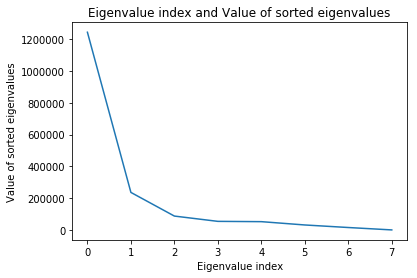

In [114]:
plt.plot(eigvalues_sort)

plt.title('Eigenvalue index and Value of sorted eigenvalues')
plt.xlabel('Eigenvalue index')
plt.ylabel('Value of sorted eigenvalues')

plt.show()

## Choose the necessary no.of principle components:

In [115]:
reduced_data = np.array(eigvectors_sort[:8]).transpose()

Now we try to find the projected data. This will form the eigen space.

In [116]:
proj_data = np.dot(training_tensor.transpose(),reduced_data)
proj_data = proj_data.transpose()

## Plot eigen faces

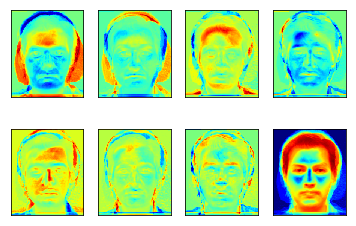

In [117]:
for i in range(proj_data.shape[0]):
    img = proj_data[i].reshape(height,width)
    plt.subplot(2,4,1+i)
    plt.imshow(img, cmap='jet')
    plt.tick_params(labelleft='off', labelbottom='off', bottom='off',top='off',right='off',left='off', which='both')
plt.show()

## Finding weights for each traning image

In [118]:
w = np.array([np.dot(proj_data,i) for i in normalised_training_tensor])
w

array([[-8.48287612e+07,  5.81765456e+07,  4.32101930e+07,
        -7.76647463e+07, -3.06341089e+07, -3.58272786e+07,
         3.53176153e+07, -3.65986944e+08],
       [ 8.90553605e+07, -4.26457404e+07,  6.83431225e+07,
         2.56112699e+07, -1.89660204e+07,  3.27984752e+07,
        -1.63052275e+07,  1.88968379e+08],
       [ 6.49888673e+07,  1.91766896e+07, -5.08976401e+07,
        -6.15416348e+07, -1.02271740e+07,  2.29160969e+07,
        -4.87793668e+06, -2.58201554e+08],
       [ 1.63772788e+08, -3.62801041e+07, -4.07933003e+07,
         4.85649446e+07, -2.11225024e+07,  2.23707416e+06,
         1.88350738e+07,  5.22873512e+07],
       [-2.50823074e+07,  7.92886248e+07,  6.20549912e+06,
         3.76311039e+07,  5.70068630e+07,  2.62025963e+07,
         3.84041861e+06,  7.23023548e+07],
       [-3.03507468e+08, -1.07059520e+08, -2.15641534e+07,
         4.34624113e+07,  1.37673278e+07,  2.06872576e+07,
        -1.02386688e+07,  5.84940259e+08],
       [-5.73401449e+07,  8.295272

## Now we recognise unknown face!

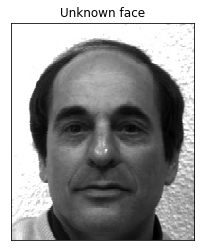

In [119]:
unknown_face        = plt.imread('Dataset/subject12.normal.jpg')
unknown_face_vector = np.array(unknown_face, dtype='float64').flatten()

plt.imshow(unknown_face, cmap='gray')
plt.title('Unknown face')
plt.tick_params(labelleft='off', labelbottom='off', bottom='off',top='off',right='off',left='off', which='both')
plt.show()

In [120]:
unknown_face.shape

(231, 195)

### Normalise unknown face

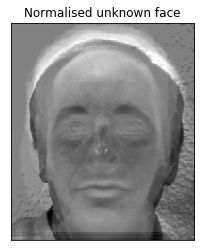

In [121]:
normalised_uface_vector = np.subtract(unknown_face_vector,mean_face)

plt.imshow(normalised_uface_vector.reshape(height, width), cmap='gray')
plt.title('Normalised unknown face')
plt.tick_params(labelleft='off', labelbottom='off', bottom='off',top='off',right='off',left='off', which='both')
plt.show()

### Wieghts of uknown face

Projecting the normalized vector onto the eigenspace, to find out the weights:

In [122]:
w_unknown = np.dot(proj_data, unknown_face_vector)
w_unknown

array([ 4.70038929e+07,  1.65543498e+08,  2.16510446e+07, -1.60182424e+08,
       -3.66812704e+07, -9.24751216e+07,  3.78133854e+07, -3.03560604e+09])

Finding the $min|W - W_{unknown}|$

In [123]:
diff  = w - w_unknown
norms = np.linalg.norm(diff, axis=1)
print(norms)
min(norms)

[2.67699446e+09 3.24015846e+09 2.78685363e+09 3.10588163e+09
 3.12011469e+09 3.65602580e+09 2.96379171e+09 2.85798459e+09]


2676994461.4348407

## Reconizing all test images

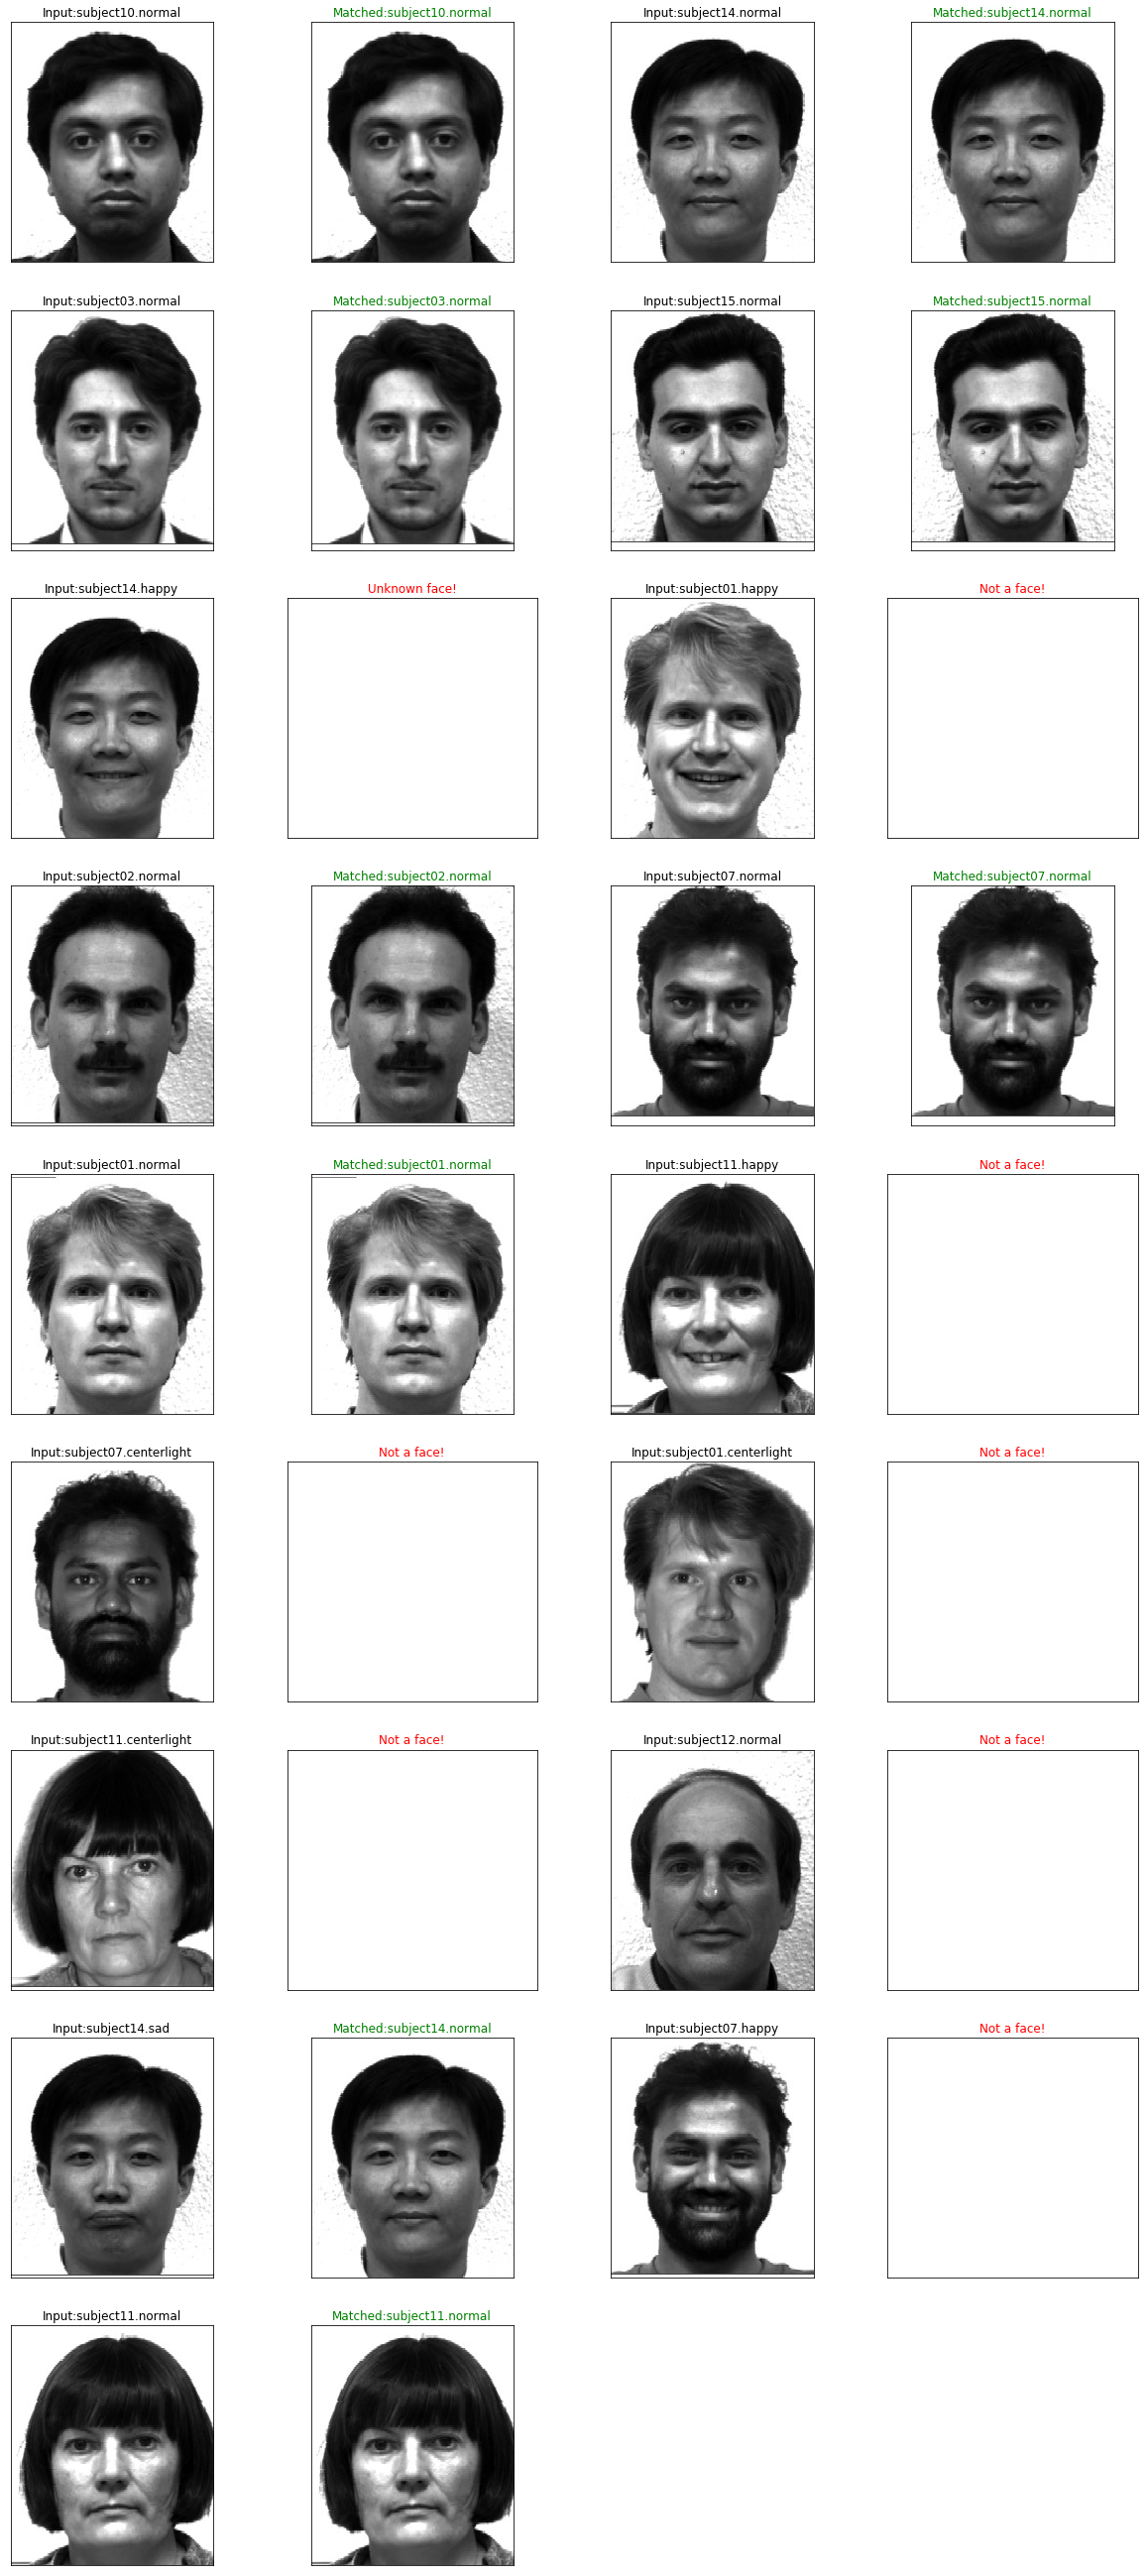

Correct predictions: 9/17 = 52.94117647058824%


In [124]:
count        = 0
num_images   = 0
correct_pred = 0
def recogniser(img, train_image_names,proj_data,w):
    global count,highest_min,num_images,correct_pred
    unknown_face        = plt.imread('Dataset/'+img)
    num_images          += 1
    unknown_face_vector = np.array(unknown_face, dtype='float64').flatten()
    normalised_uface_vector = np.subtract(unknown_face_vector,mean_face)
    
    plt.subplot(9,4,1+count)
    plt.imshow(unknown_face, cmap='gray')
    plt.title('Input:'+'.'.join(img.split('.')[:2]))
    plt.tick_params(labelleft='off', labelbottom='off', bottom='off',top='off',right='off',left='off', which='both')
    count+=1
    
    w_unknown = np.dot(proj_data, normalised_uface_vector)
    diff  = w - w_unknown
    norms = np.linalg.norm(diff, axis=1)
    index = np.argmin(norms)
    
    t1 = 100111536
    #t1 = 200535910.268 # working with 6 faces
    #t0 = 86528212
    t0 = 88831687
    #t0 = 143559033 # working with 6 faces
    
    if norms[index] < t1:
        plt.subplot(9,4,1+count)
        if norms[index] < t0: # It's a face
            if img.split('.')[0] == train_image_names[index].split('.')[0]:
                plt.title('Matched:'+'.'.join(train_image_names[index].split('.')[:2]), color='g')
                plt.imshow(imread('Dataset/'+train_image_names[index]), cmap='gray')
                
                correct_pred += 1
            else:
                plt.title('Matched:'+'.'.join(train_image_names[index].split('.')[:2]), color='r')
                plt.imshow(imread('Dataset/'+train_image_names[index]), cmap='gray')
        else:
            if img.split('.')[0] not in [i.split('.')[0] for i in train_image_names] and img.split('.')[0] != 'apple':
                plt.title('Unknown face!', color='g')
                correct_pred += 1
            else:
                plt.title('Unknown face!', color='r')
        plt.tick_params(labelleft='off', labelbottom='off', bottom='off',top='off',right='off',left='off', which='both')
        plt.subplots_adjust(right=1.2, top=2.5)
    else:     
        plt.subplot(9,4,1+count)
        if len(img.split('.')) == 3:
            plt.title('Not a face!', color='r')
        else:
            plt.title('Not a face!', color='g')
            correct_pred += 1
        plt.tick_params(labelleft='off', labelbottom='off', bottom='off',top='off',right='off',left='off', which='both')
    count+=1

fig = plt.figure(figsize=(15, 15))
for i in range(len(test_image_names)):
    recogniser(test_image_names[i], train_image_names,proj_data,w)

plt.show()

print('Correct predictions: {}/{} = {}%'.format(correct_pred, num_images, correct_pred/num_images*100.00))

## Normalised images

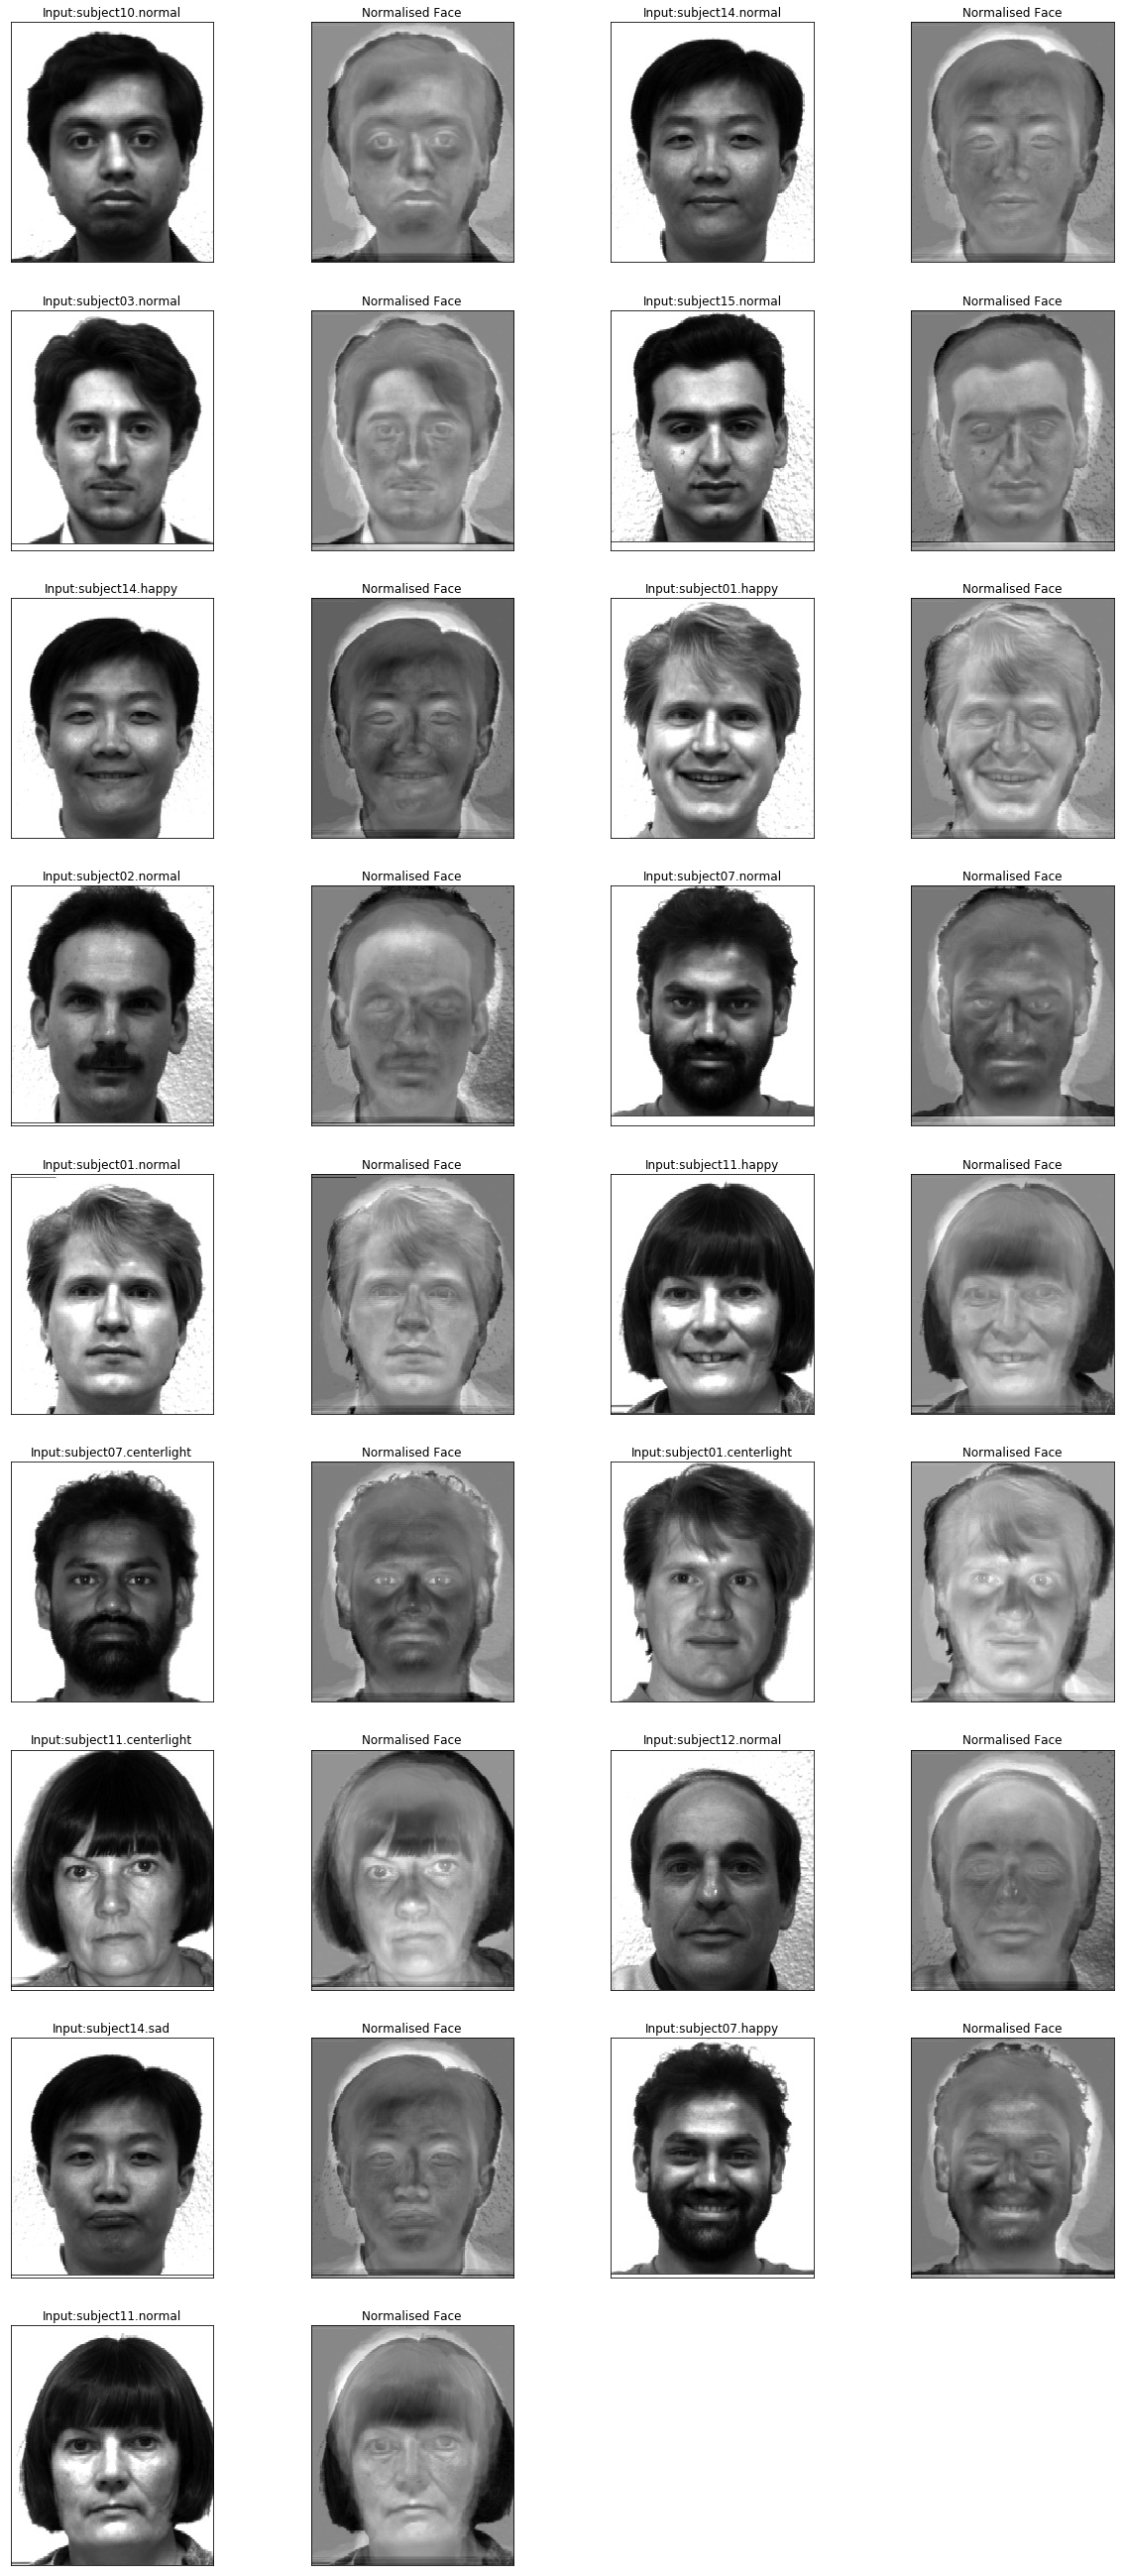

In [126]:
count        = 0
def recogniser(img, train_image_names,proj_data,w):
    global count
    unknown_face        = plt.imread('Dataset/'+img)
    unknown_face_vector = np.array(unknown_face, dtype='float64').flatten()
    normalised_uface_vector = np.subtract(unknown_face_vector,mean_face)
    
    plt.subplot(9,4,1+count)
    plt.imshow(unknown_face, cmap='gray')
    plt.title('Input:'+'.'.join(img.split('.')[:2]))
    plt.tick_params(labelleft='off', labelbottom='off', bottom='off',top='off',right='off',left='off', which='both')
    count+=1
    
    plt.subplot(9,4,1+count)
    plt.imshow(normalised_uface_vector.reshape(height, width), cmap='gray')
    plt.title('Normalised Face')
    plt.tick_params(labelleft='off', labelbottom='off', bottom='off',top='off',right='off',left='off', which='both')
    plt.subplots_adjust(right=1.2, top=2.5)
    count+=1

fig = plt.figure(figsize=(15, 15))
for i in range(len(test_image_names)):
    recogniser(test_image_names[i], train_image_names,proj_data,w)

plt.show()

# Another Dataset

In [152]:
import matplotlib.image as img
image = img.imread('Face/Data/David.1.jpg')
image.shape

(250, 250)

In [153]:
dataset_path = 'Face/Data/'
dataset_dir  = os.listdir(dataset_path)

width  = 250
height = 250

In [213]:

train_image_names = ['Ariel.1.jpg', 
                     'Arnold.1.jpg', 
                     'Blair.1.jpg', 
                     'Chavez.1.jpg', 
                     'da_Silva.1.jpg', 
                     'David.1.jpg', 
                     'Gerhard.1.jpg', 
                     'Gloria.1.jpg',
                    'Jennifer.1.jpg',
                    'Koizumi.1.jpg',
                    'Nicole.1.jpg',
                    'Putin.1.jpg',
                    'Serena.1.jpg']
training_tensor   = np.ndarray(shape=(len(train_image_names), height*width), dtype=np.float64)

#for i in range(1,4000):
 #   train_image_names.append(str(i)+'.jpg')
#training_tensor   = np.ndarray(shape=(len(train_image_names), height*width), dtype=np.float64)

for i in range(len(train_image_names)):
    img = plt.imread(dataset_path + train_image_names[i])
    training_tensor[i,:] = np.array(img, dtype='float64').flatten()


test_image_names = list(set(dataset_dir) -  set(train_image_names)) #[i for i in dataset_dir if i not in train_image_names]
testing_tensor   = np.ndarray(shape=(len(test_image_names), height*width), dtype=np.float64)

for i in range(len(test_image_names)):
    img = imread(dataset_path + test_image_names[i])
    testing_tensor[i,:] = np.array(img, dtype='float64').flatten()

/home/hekmat/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


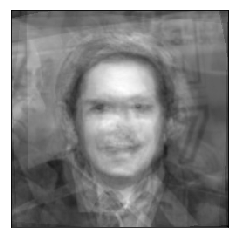

In [214]:
mean_face = np.zeros((1,height*width))

for i in training_tensor:
    mean_face = np.add(mean_face,i)

mean_face = np.divide(mean_face,float(len(train_image_names))).flatten()

plt.imshow(mean_face.reshape(height, width), cmap='gray')
plt.tick_params(labelleft='off', labelbottom='off', bottom='off',top='off',right='off',left='off', which='both')
plt.show()

In [215]:
normalised_training_tensor = np.ndarray(shape=(len(train_image_names), height*width))

for i in range(len(train_image_names)):
    normalised_training_tensor[i] = np.subtract(training_tensor[i],mean_face)

In [216]:
for i in range(len(train_image_names)):
    img = normalised_training_tensor[i].reshape(height,width)


In [240]:
cov_matrix = np.cov(normalised_training_tensor)
cov_matrix = np.divide(cov_matrix,len(cov_matrix))
print('Covariance matrix of X: \n%s' %cov_matrix)

Covariance matrix of X: 
[[ 2.60209997e+02 -3.82797150e+01 -5.01532800e+01 -3.41806127e+01
   1.55463821e+01 -4.33134937e+00 -3.09257049e+01 -3.99345320e+01
   3.91880041e+01 -8.87051332e+01 -3.91660801e+01  5.17917214e+00
   5.55285225e+00]
 [-3.82797150e+01  2.21055522e+02  6.02790869e+01  2.13940459e+01
  -6.74312367e+01 -1.42782201e+02 -1.14180794e+02  7.27630155e+01
  -1.01219862e+02  5.39305223e+01  9.70263677e+01 -2.03521137e+00
  -6.05195395e+01]
 [-5.01532800e+01  6.02790869e+01  2.48001499e+02 -5.24031325e-02
  -1.15535390e+02 -1.01605311e+02 -6.81502365e+01  1.10943976e+01
  -4.52418245e+01  4.79817788e+00  5.14111686e+01  2.32221179e+01
  -1.80680032e+01]
 [-3.41806127e+01  2.13940459e+01 -5.24031325e-02  6.32106719e+01
   9.00250657e+00 -9.42142549e+00 -5.01346022e+00  1.68955804e+01
  -3.08904158e+01  1.49186338e+01  2.23298481e+00 -1.51198971e+01
  -3.29762090e+01]
 [ 1.55463821e+01 -6.74312367e+01 -1.15535390e+02  9.00250657e+00
   2.84037639e+02  2.58069793e+01  1.6730

In [241]:
cov_matrix.shape

(13, 13)

In [242]:
import datetime
a = datetime.datetime.now()
eigenvalues, eigenvectors, =  np.linalg.eig(cov_matrix)
b = datetime.datetime.now()

print(b-a)
print('Eigenvectors of Cov(X): \n%s' %eigenvectors)
print('\nEigenvalues of Cov(X): \n%s' %eigenvalues)


0:00:00.000489
Eigenvectors of Cov(X): 
[[-1.36033282e-01 -5.77978527e-01 -2.21858633e-02  7.31351765e-02
  -2.77350098e-01 -6.79656889e-01  7.30933622e-02  2.21257216e-02
   3.28852374e-02  8.13232610e-02  1.53489687e-01  2.29283611e-01
  -1.14372553e-01]
 [ 4.01469897e-01  1.04151464e-02 -1.13084718e-01  1.05800859e-01
  -2.77350098e-01 -1.38864142e-01 -9.05441918e-02 -2.07434444e-01
   4.47064775e-01 -4.39416254e-01  1.78711336e-01 -4.91434646e-01
   2.99755901e-02]
 [ 2.90871295e-01 -5.96154098e-02  1.35318428e-01 -4.92818673e-01
  -2.77350098e-01  2.12022797e-01 -4.16249634e-01 -1.14005752e-01
  -1.88362087e-03  4.54104806e-02  3.79313867e-01  4.24066123e-01
   1.29398658e-01]
 [ 4.72588392e-02  1.21118883e-01 -8.90923215e-02  6.34944415e-02
  -2.77350098e-01  3.93373771e-02 -1.37288097e-02  9.24513107e-01
  -2.94129199e-03 -9.98694987e-02  1.45910415e-01 -2.25566499e-02
   7.72213784e-02]
 [-2.50692398e-01 -1.20556231e-01 -4.29036767e-01  5.47397814e-01
  -2.77350098e-01  4.35566

In [243]:
eig_pairs = [(eigenvalues[index], eigenvectors[:,index]) for index in range(len(eigenvalues))]

# Sort the eigen pairs in descending order:
eig_pairs.sort(reverse=True)
eigvalues_sort  = [eig_pairs[index][0] for index in range(len(eigenvalues))]
eigvectors_sort = [eig_pairs[index][1] for index in range(len(eigenvalues))]

In [244]:
eigenvectors.shape

(13, 13)

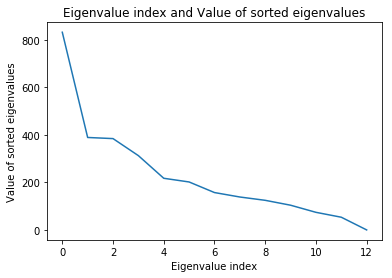

In [245]:
plt.plot(eigvalues_sort)

plt.title('Eigenvalue index and Value of sorted eigenvalues')
plt.xlabel('Eigenvalue index')
plt.ylabel('Value of sorted eigenvalues')

plt.show()

In [248]:
a = datetime.datetime.now()
eigvals, eigvecs = fsvd(cov_matrix, k=len(cov_matrix))
b = datetime.datetime.now()

print(b-a)

print('Eigenvectors of Cov(X): \n%s' %eigvecs.T)
print('\nEigenvalues of Cov(X): \n%s' %eigvals)

0:00:00.001091
Eigenvectors of Cov(X): 
[[-1.36033282e-01  2.21858633e-02  5.77978527e-01  7.31351765e-02
  -6.79656889e-01 -7.30933622e-02 -1.53489687e-01  1.14372553e-01
   2.29283611e-01 -8.13232610e-02  3.28852374e-02  2.21257216e-02
  -2.77350098e-01]
 [ 4.01469897e-01  1.13084718e-01 -1.04151464e-02  1.05800859e-01
  -1.38864142e-01  9.05441918e-02 -1.78711336e-01 -2.99755901e-02
  -4.91434646e-01  4.39416254e-01  4.47064775e-01 -2.07434444e-01
  -2.77350098e-01]
 [ 2.90871295e-01 -1.35318428e-01  5.96154098e-02 -4.92818673e-01
   2.12022797e-01  4.16249634e-01 -3.79313867e-01 -1.29398658e-01
   4.24066123e-01 -4.54104806e-02 -1.88362087e-03 -1.14005752e-01
  -2.77350098e-01]
 [ 4.72588392e-02  8.90923215e-02 -1.21118883e-01  6.34944415e-02
   3.93373771e-02  1.37288097e-02 -1.45910415e-01 -7.72213784e-02
  -2.25566499e-02  9.98694987e-02 -2.94129199e-03  9.24513107e-01
  -2.77350098e-01]
 [-2.50692398e-01  4.29036767e-01  1.20556231e-01  5.47397814e-01
   4.35566026e-01  3.12443

In [249]:
eig_pairs_fsvd = [(eigvals[index], eigvecs.T[:,index]) for index in range(len(eigvals))]


# Sort the eigen pairs in descending order:
eig_pairs_fsvd.sort(reverse=True)
eigvalues_sort_fsvd  = [eig_pairs_fsvd[index][0] for index in range(len(eigvals))]
eigvectors_sort_fsvd = [eig_pairs_fsvd[index][1] for index in range(len(eigvals))]

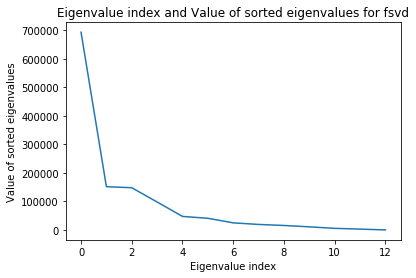

In [250]:
plt.plot(eigvalues_sort_fsvd)

plt.title('Eigenvalue index and Value of sorted eigenvalues for fsvd')
plt.xlabel('Eigenvalue index')
plt.ylabel('Value of sorted eigenvalues')

plt.show()

In [251]:
reduced_data = np.array(eigvectors_sort[:20]).transpose()

In [252]:
proj_data = np.dot(training_tensor.transpose(),reduced_data)
proj_data = proj_data.transpose()

/home/hekmat/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


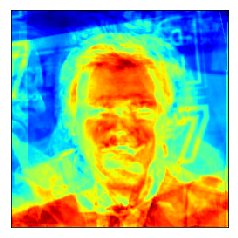

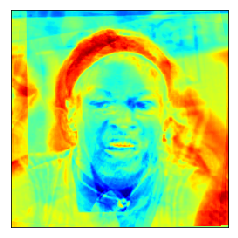

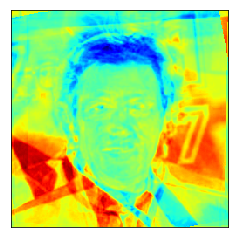

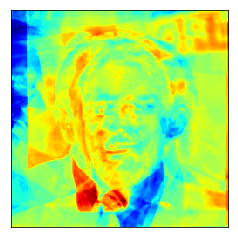

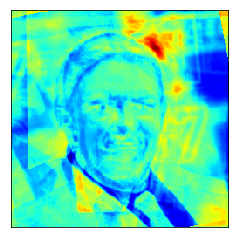

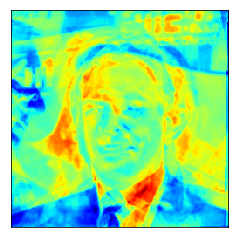

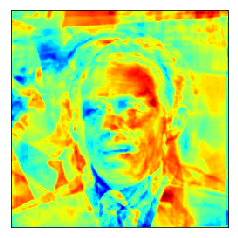

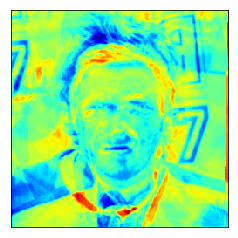

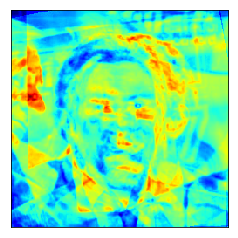

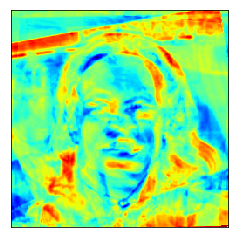

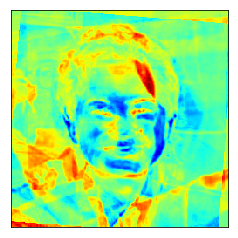

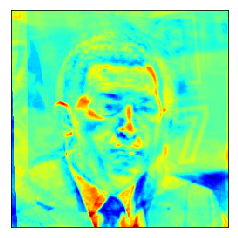

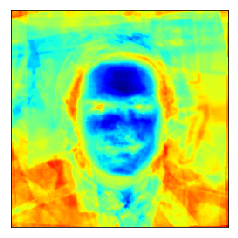

In [253]:
for i in range(proj_data.shape[0]):
    img = proj_data[i].reshape(height,width)
    plt.imshow(img, cmap='jet')
    plt.tick_params(labelleft='off', labelbottom='off', bottom='off',top='off',right='off',left='off', which='both')
    plt.show()

In [254]:
w = np.array([np.dot(proj_data,i) for i in normalised_training_tensor])
w

array([[-1.99035700e+08,  4.02828314e+07, -1.36088174e+08,
         2.16219970e+07, -1.63934245e+08,  3.36283588e+07,
         2.26256810e+07, -3.10882123e+07,  2.93849105e+07,
         6.17531102e+07,  1.49696342e+07, -5.59406513e+06,
        -5.67763792e+08],
       [ 5.13522794e+08, -1.42719198e+08, -9.74603549e+07,
         2.00439132e+07,  7.44968360e+07, -6.37681001e+07,
         1.60686273e+07,  4.45331087e+07, -6.37054380e+07,
        -1.61224008e+08, -2.44294368e+06,  5.80851005e+06,
         1.08569154e+09],
       [ 3.59217372e+08, -2.89918390e+07, -8.62569018e+07,
        -1.29878289e+08,  1.03974650e+08, -1.01145264e+08,
         4.39467403e+07,  4.22108643e+07,  3.36079393e+07,
        -7.94610777e+07, -1.98311624e+07,  4.99817147e+06,
         7.30627492e+08],
       [ 1.02160728e+08, -5.92150135e+07,  8.63241459e+06,
         1.41528932e+07,  3.56878770e+07, -1.64434293e+07,
         1.66889526e+07,  2.06397549e+07, -6.32478698e+06,
        -4.44409187e+07, -8.69724430e

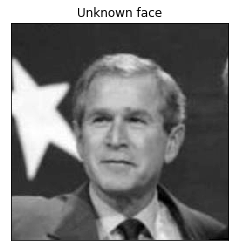

In [255]:
unknown_face        = plt.imread('Face/Data/George_W_Bush.jpg')
unknown_face_vector = np.array(unknown_face, dtype='float64').flatten()

plt.imshow(unknown_face, cmap='gray')
plt.title('Unknown face')
plt.tick_params(labelleft='off', labelbottom='off', bottom='off',top='off',right='off',left='off', which='both')
plt.show()

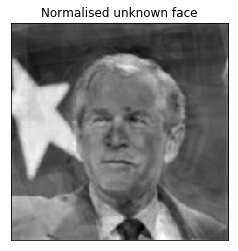

In [256]:
normalised_uface_vector = np.subtract(unknown_face_vector,mean_face)

plt.imshow(normalised_uface_vector.reshape(height, width), cmap='gray')
plt.title('Normalised unknown face')
plt.tick_params(labelleft='off', labelbottom='off', bottom='off',top='off',right='off',left='off', which='both')
plt.show()

In [257]:
w_unknown = np.dot(proj_data, unknown_face_vector)
w_unknown

array([-3.49732363e+08,  1.90380247e+08,  1.62338354e+08,  3.06802002e+06,
       -1.94341627e+08,  7.94654360e+07,  9.81058270e+06, -7.40997547e+07,
        5.59808298e+07,  2.03113946e+08,  4.88131803e+07, -3.21816946e+07,
       -2.10595447e+09])

In [258]:
diff  = w - w_unknown
norms = np.linalg.norm(diff, axis=1)
print(norms)
min(norms)

[1.59004853e+09 3.37173439e+09 2.98314520e+09 2.52719384e+09
 2.38733868e+09 9.46128521e+08 1.04348618e+09 2.96048339e+09
 1.91770730e+09 1.75624221e+09 2.22015657e+09 2.80688412e+09
 2.04276161e+09]


946128520.881857

### Percision for Regular SVD

Correct predictions: 65/695 = 9.352517985611511%


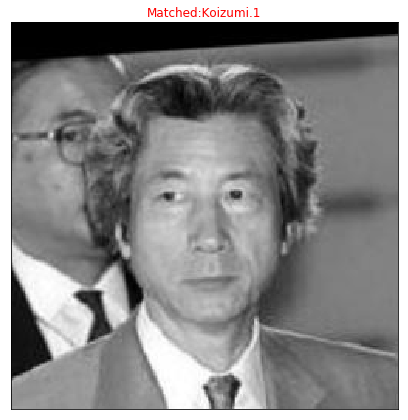

In [259]:
count        = 0
num_images   = 0
correct_pred = 0
def recogniser(img, train_image_names,proj_data,w):
    global count,highest_min,num_images,correct_pred
    unknown_face        = plt.imread('Face/Data/'+img)
    num_images          += 1
    unknown_face_vector = np.array(unknown_face, dtype='float64').flatten()
    normalised_uface_vector = np.subtract(unknown_face_vector,mean_face)
    
#     plt.subplot(9,4,1+count)
    plt.imshow(unknown_face, cmap='gray')
    plt.title('Input:'+'.'.join(img.split('.')[:2]))
    plt.tick_params(labelleft='off', labelbottom='off', bottom='off',top='off',right='off',left='off', which='both')
    count+=1
    
    w_unknown = np.dot(proj_data, normalised_uface_vector)
    diff  = w - w_unknown
    norms = np.linalg.norm(diff, axis=1)
    index = np.argmin(norms)
    
    t1 = 10**11
    #t1 = 200535910.268 # working with 6 faces
    #t0 = 86528212
    t0 = 10**10
    #t0 = 143559033 # working with 6 faces
    
    if norms[index] < t1:
#         plt.subplot(9,4,1+count)
        if norms[index] < t0: # It's a face
            if img.split('.')[0] == train_image_names[index].split('.')[0]:
                plt.title('Matched:'+'.'.join(train_image_names[index].split('.')[:2]), color='g')
                plt.imshow(imread('Face/Data/'+train_image_names[index]), cmap='gray')
                
                correct_pred += 1
            else:
                plt.title('Matched:'+'.'.join(train_image_names[index].split('.')[:2]), color='r')
                plt.imshow(imread('Face/Data/'+train_image_names[index]), cmap='gray')
        else:
            if img.split('.')[0] not in [i.split('.')[0] for i in train_image_names] and img.split('.')[0] != 'apple':
                plt.title('Unknown face!', color='g')
                correct_pred += 1
            else:
                plt.title('Unknown face!', color='r')
        plt.tick_params(labelleft='off', labelbottom='off', bottom='off',top='off',right='off',left='off', which='both')
        plt.subplots_adjust(right=1.2, top=2.5)
    else:     
        #plt.subplot(9,4,1+count)
        if len(img.split('.')) == 3:
            plt.title('Not a face!', color='r')
        else:
            plt.title('Not a face!', color='g')
            correct_pred += 1
        plt.tick_params(labelleft='off', labelbottom='off', bottom='off',top='off',right='off',left='off', which='both')
    count+=1

fig = plt.figure(figsize=(5, 5))
for i in range(len(test_image_names)):
    recogniser(test_image_names[i], train_image_names,proj_data,w)

#     plt.show()

print('Correct predictions: {}/{} = {}%'.format(correct_pred, num_images, correct_pred/num_images*100.00))

### Percision for Regular Fsvd

In [260]:
reduced_data = np.array(eigvectors_sort_fsvd[:20]).transpose()

In [261]:
proj_data = np.dot(training_tensor.transpose(),reduced_data)
proj_data = proj_data.transpose()

/home/hekmat/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


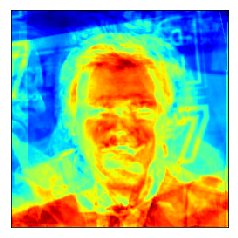

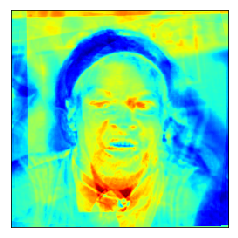

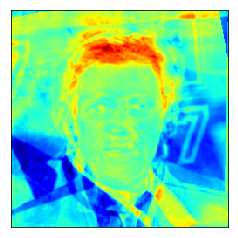

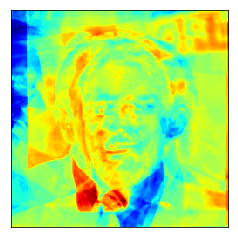

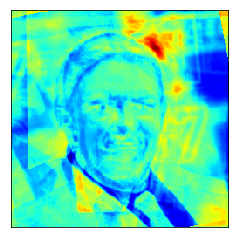

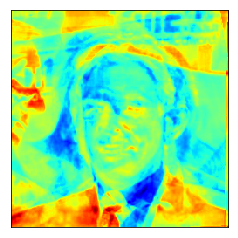

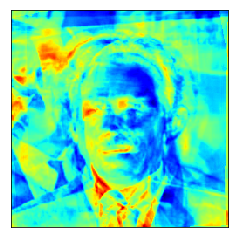

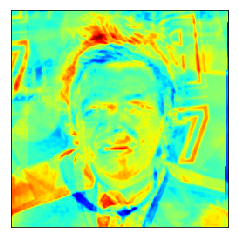

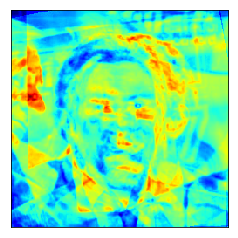

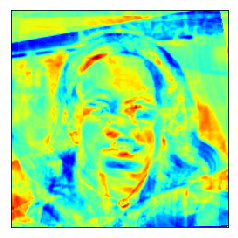

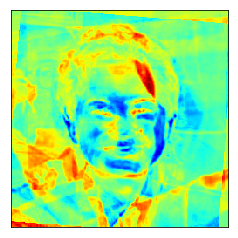

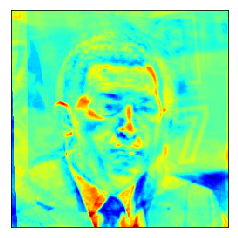

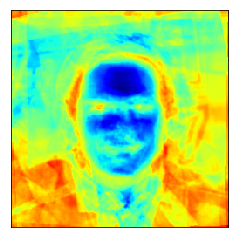

In [262]:
for i in range(proj_data.shape[0]):
    img = proj_data[i].reshape(height,width)
    plt.imshow(img, cmap='jet')
    plt.tick_params(labelleft='off', labelbottom='off', bottom='off',top='off',right='off',left='off', which='both')
    plt.show()

In [263]:
w = np.array([np.dot(proj_data,i) for i in normalised_training_tensor])
w

array([[-1.99035700e+08, -4.02828314e+07,  1.36088174e+08,
         2.16219970e+07, -1.63934245e+08, -3.36283588e+07,
        -2.26256810e+07,  3.10882123e+07,  2.93849105e+07,
        -6.17531102e+07,  1.49696342e+07, -5.59406513e+06,
        -5.67763792e+08],
       [ 5.13522794e+08,  1.42719198e+08,  9.74603549e+07,
         2.00439132e+07,  7.44968360e+07,  6.37681001e+07,
        -1.60686273e+07, -4.45331087e+07, -6.37054380e+07,
         1.61224008e+08, -2.44294368e+06,  5.80851005e+06,
         1.08569154e+09],
       [ 3.59217372e+08,  2.89918390e+07,  8.62569018e+07,
        -1.29878289e+08,  1.03974650e+08,  1.01145264e+08,
        -4.39467403e+07, -4.22108643e+07,  3.36079393e+07,
         7.94610777e+07, -1.98311624e+07,  4.99817147e+06,
         7.30627492e+08],
       [ 1.02160728e+08,  5.92150135e+07, -8.63241459e+06,
         1.41528932e+07,  3.56878770e+07,  1.64434293e+07,
        -1.66889526e+07, -2.06397549e+07, -6.32478698e+06,
         4.44409187e+07, -8.69724430e

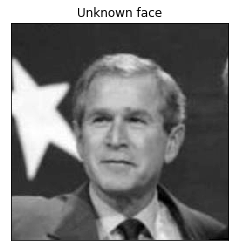

In [264]:
unknown_face        = plt.imread('Face/Data/George_W_Bush.jpg')
unknown_face_vector = np.array(unknown_face, dtype='float64').flatten()

plt.imshow(unknown_face, cmap='gray')
plt.title('Unknown face')
plt.tick_params(labelleft='off', labelbottom='off', bottom='off',top='off',right='off',left='off', which='both')
plt.show()

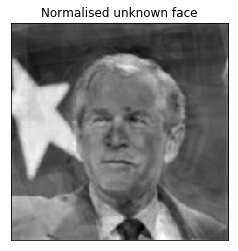

In [265]:
normalised_uface_vector = np.subtract(unknown_face_vector,mean_face)

plt.imshow(normalised_uface_vector.reshape(height, width), cmap='gray')
plt.title('Normalised unknown face')
plt.tick_params(labelleft='off', labelbottom='off', bottom='off',top='off',right='off',left='off', which='both')
plt.show()

In [266]:
w_unknown = np.dot(proj_data, unknown_face_vector)
w_unknown

array([-3.49732363e+08, -1.90380247e+08, -1.62338354e+08,  3.06802002e+06,
       -1.94341627e+08, -7.94654360e+07, -9.81058270e+06,  7.40997547e+07,
        5.59808298e+07, -2.03113946e+08,  4.88131803e+07, -3.21816946e+07,
       -2.10595447e+09])

In [267]:
diff  = w - w_unknown
norms = np.linalg.norm(diff, axis=1)
print(norms)
min(norms)

[1.59004853e+09 3.37173439e+09 2.98314520e+09 2.52719384e+09
 2.38733868e+09 9.46128521e+08 1.04348618e+09 2.96048339e+09
 1.91770730e+09 1.75624221e+09 2.22015657e+09 2.80688412e+09
 2.04276161e+09]


946128520.8818573

Correct predictions: 65/695 = 9.352517985611511%


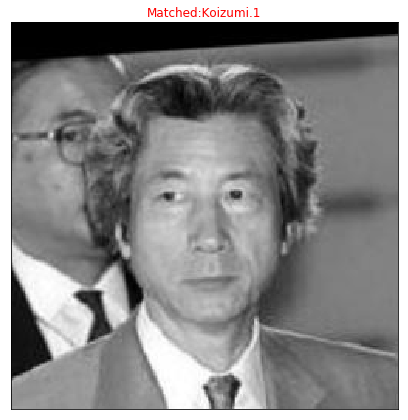

In [268]:
count        = 0
num_images   = 0
correct_pred = 0
def recogniser(img, train_image_names,proj_data,w):
    global count,highest_min,num_images,correct_pred
    unknown_face        = plt.imread('Face/Data/'+img)
    num_images          += 1
    unknown_face_vector = np.array(unknown_face, dtype='float64').flatten()
    normalised_uface_vector = np.subtract(unknown_face_vector,mean_face)
    
#     plt.subplot(9,4,1+count)
    plt.imshow(unknown_face, cmap='gray')
    plt.title('Input:'+'.'.join(img.split('.')[:2]))
    plt.tick_params(labelleft='off', labelbottom='off', bottom='off',top='off',right='off',left='off', which='both')
    count+=1
    
    w_unknown = np.dot(proj_data, normalised_uface_vector)
    diff  = w - w_unknown
    norms = np.linalg.norm(diff, axis=1)
    index = np.argmin(norms)
    
    t1 = 10**11
    #t1 = 200535910.268 # working with 6 faces
    #t0 = 86528212
    t0 = 10**10
    #t0 = 143559033 # working with 6 faces
    
    if norms[index] < t1:
#         plt.subplot(9,4,1+count)
        if norms[index] < t0: # It's a face
            if img.split('.')[0] == train_image_names[index].split('.')[0]:
                plt.title('Matched:'+'.'.join(train_image_names[index].split('.')[:2]), color='g')
                plt.imshow(imread('Face/Data/'+train_image_names[index]), cmap='gray')
                
                correct_pred += 1
            else:
                plt.title('Matched:'+'.'.join(train_image_names[index].split('.')[:2]), color='r')
                plt.imshow(imread('Face/Data/'+train_image_names[index]), cmap='gray')
        else:
            if img.split('.')[0] not in [i.split('.')[0] for i in train_image_names] and img.split('.')[0] != 'apple':
                plt.title('Unknown face!', color='g')
                correct_pred += 1
            else:
                plt.title('Unknown face!', color='r')
        plt.tick_params(labelleft='off', labelbottom='off', bottom='off',top='off',right='off',left='off', which='both')
        plt.subplots_adjust(right=1.2, top=2.5)
    else:     
        #plt.subplot(9,4,1+count)
        if len(img.split('.')) == 3:
            plt.title('Not a face!', color='r')
        else:
            plt.title('Not a face!', color='g')
            correct_pred += 1
        plt.tick_params(labelleft='off', labelbottom='off', bottom='off',top='off',right='off',left='off', which='both')
    count+=1

fig = plt.figure(figsize=(5, 5))
for i in range(len(test_image_names)):
    recogniser(test_image_names[i], train_image_names,proj_data,w)

#     plt.show()

print('Correct predictions: {}/{} = {}%'.format(correct_pred, num_images, correct_pred/num_images*100.00))

In this part we obsereved that the accuracy don't have any difference in both cases, But the timing for implmenting Fsvd is less than regular SVD. 

## Conclusion 

First we went through theory Singular Value Decomposition and we figured out that for large datasets it is memory taking and not time effiecient to calculate SVD by conventional library in Python. Then we decided to implement Randomize SVD and Fast SVD for two applications to compare the performance and output. 

At the end we understood using fast SVD and randomize SVD can be a good replacement for usual SVD to increase the speed and Efficiency.